In [1]:
import tensorflow as tf
import poisson_CNN
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl

mpl.rcParams['figure.dpi']=300
warnings.filterwarnings("ignore")
tf.keras.backend.set_floatx('float32')

img_path = '/home/ago14/storage/ali/manuscript/results/training_set_examples/'
examplename = 'tset_pcnn_1'
case = 'pcnn_'

In [2]:
bc_nn_params = {'x_output_resolution' : 64, 'initial_kernel_size':13, 'final_kernel_size': 3, 'conv1d_final_channels': 256, 'kernel_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4), 'bias_regularizer' : tf.keras.regularizers.L1L2(l2 = 1e-4)}
hpnn_params = {'pooling_block_number': 7, 'use_deconv_upsample': True, 'initial_kernel_size': 19, 'final_kernel_size': 3, 'post_dx_einsum_conv_block_number': 9, 'kernel_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4), 'bias_regularizer': tf.keras.regularizers.L1L2(l2 = 1e-4)}
bc_nn_weights = 'DBCNN_direct_192_228_5e-3_5e-2_2.h5'
hpnn_weights = 'poisson_CNN_old/weights/Homogeneous_Poisson_NN/HPNN_fluidnet_reversekernelsize_regularizer.h5'
mod = poisson_CNN.models.Poisson_CNN(n_quadpts = 47, mse_component_weight = 1e+1, mae_component_weight = 1e+0, bc_nn_parameters = bc_nn_params, homogeneous_poisson_nn_parameters=hpnn_params, homogeneous_poisson_nn_weights = hpnn_weights, bc_nn_weights=bc_nn_weights, bc_nn_trainable=False, homogeneous_poisson_nn_trainable=False)
from IPython.display import clear_output
mod([tf.random.uniform((10,1,192,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,192), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,193), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1,192), dtype = tf.keras.backend.floatx()), tf.random.uniform((10,1), dtype = tf.keras.backend.floatx())]).shape


spp init


TensorShape([10, 1, 192, 193])

In [33]:
rosr = [[192,228],[192,228]]
dg = poisson_CNN.dataset.generators.numerical_dataset_generator(batch_size = 10, batches_per_epoch=50, return_boundaries = True, return_keras_style=True, return_dx = True, randomize_rhs_smoothness=True, randomize_boundary_smoothness=True, randomize_boundary_max_magnitudes=True, random_output_shape_range = rosr, rhs_random_smoothness_range=[4,8], random_dx_range = [0.005,0.05])


In [12]:
output_shape_range = [[192,228],[192,228]]
dg = poisson_CNN.dataset.generators.numerical_dataset_generator(batch_size = 10, batches_per_epoch = 50, rhses = 'random', return_rhs = True, return_boundaries = False, randomize_rhs_smoothness = True, nonzero_boundaries = [], return_keras_style=False, return_dx = True, return_shape = False, random_output_shape_range = output_shape_range, rhs_random_smoothness_range=[5,10])

In [34]:
inp, soln = dg.__getitem__(10)
pred = mod(inp)

In [35]:
q = np.abs(pred - tf.cast(soln, tf.keras.backend.floatx()))/np.abs(tf.cast(soln, tf.keras.backend.floatx()))
rms = tf.sqrt(tf.reduce_mean((pred - tf.cast(soln, tf.keras.backend.floatx()))**2))
mae = tf.reduce_mean(tf.abs(pred - tf.cast(soln, tf.keras.backend.floatx())))
print('Mean abs % error: ' + str(100*float(tf.reduce_mean(q[q < 1]))))
print('% of gridpts with less than 10% error: ' + str(100*float(np.sum(q < 0.1)/np.prod(q.shape))))
print('RMS error: ' + str(float(rms)))
print('MAE: ' + str(float(mae)))

Mean abs % error: 25.35969316959381
% of gridpts with less than 10% error: 26.793181016231475
RMS error: 0.06977437436580658
MAE: 0.04824294149875641


Mean abs % error of sample: 18.75271499156952
dx: 0.03659350052475929
0.03793592378497124
(218, 208)


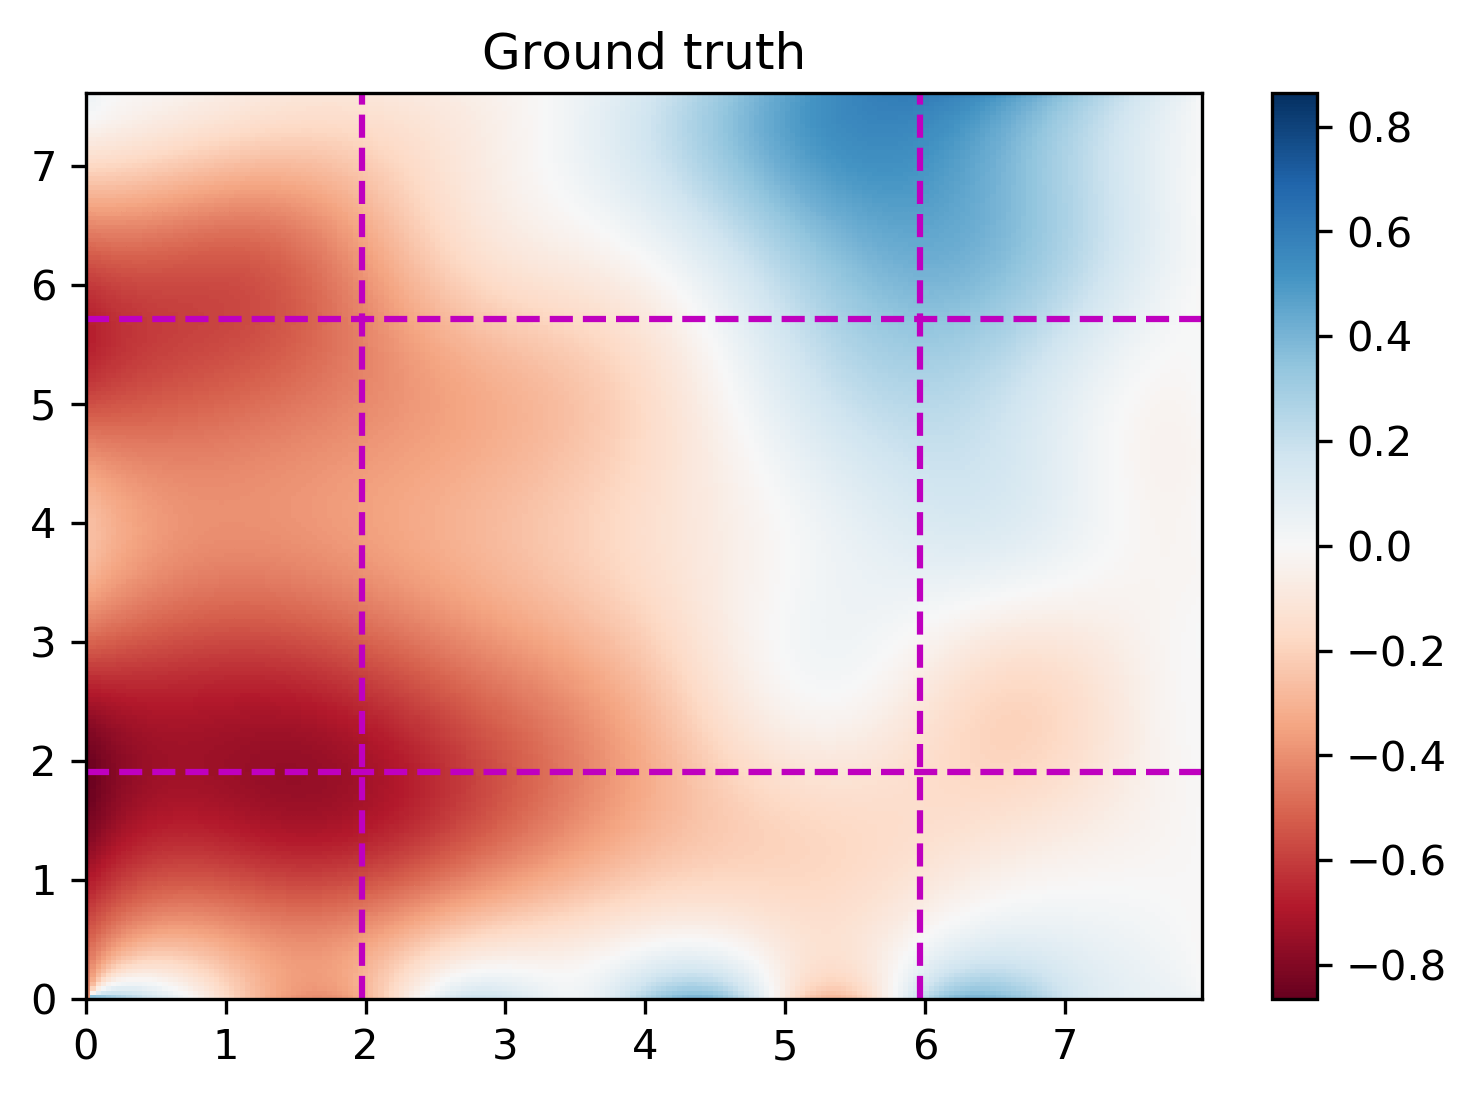

In [64]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300

saving = True

#p_r = np.random.randint(0,soln.shape[0])
print('Mean abs % error of sample: ' + str(100*float(tf.reduce_mean(q[p_r,0,...][q[p_r,0,...] < 1]))))
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = soln[p_r,0,...]
dx = float(inp[-1][p_r,0])
print('dx: ' + str(dx))
print(float(tf.reduce_mean(tf.keras.losses.mae(pred[p_r,...],tf.cast(soln[p_r,...],tf.keras.backend.floatx())))/tf.cast(tf.reduce_max(tf.abs(soln[p_r,...])),tf.keras.backend.floatx())))
print(z.shape)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Ground truth')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.axvline(x=float(inp[-1][p_r,0]*(soln.shape[-2]//4)), color = 'm', linestyle = '--')
plt.axvline(x=float(inp[-1][p_r,0]*(3*soln.shape[-2]//4)), color = 'm', linestyle = '--')
plt.axhline(y=float(inp[-1][p_r,0]*(soln.shape[-1]//4)), color = 'm', linestyle = '--')
plt.axhline(y=float(inp[-1][p_r,0]*(3*soln.shape[-1]//4)), color = 'm', linestyle = '--')

if saving:
    identifier = '_' + str(int(soln.shape[-2])) + 'x' + str(int(soln.shape[-1])) + '_dx' + ('{:.2e}'.format(dx)) + '_'
    thisimage = 'groundtruth'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

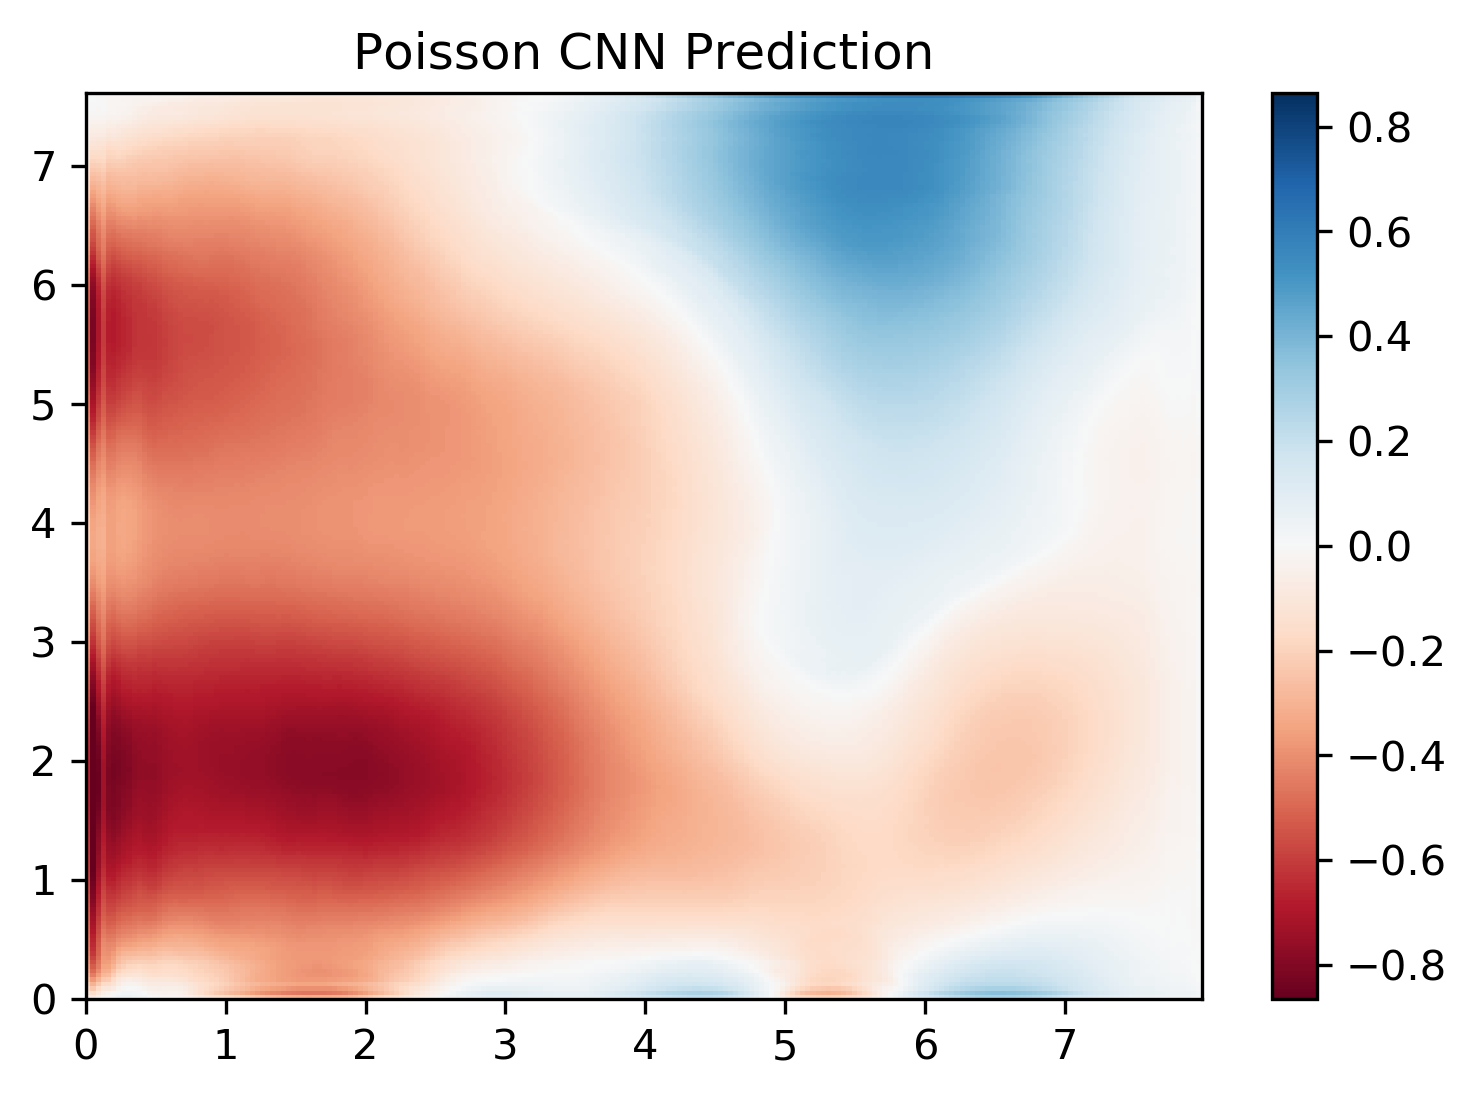

In [65]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = pred[p_r,0,...]
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Poisson CNN Prediction')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'pred'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

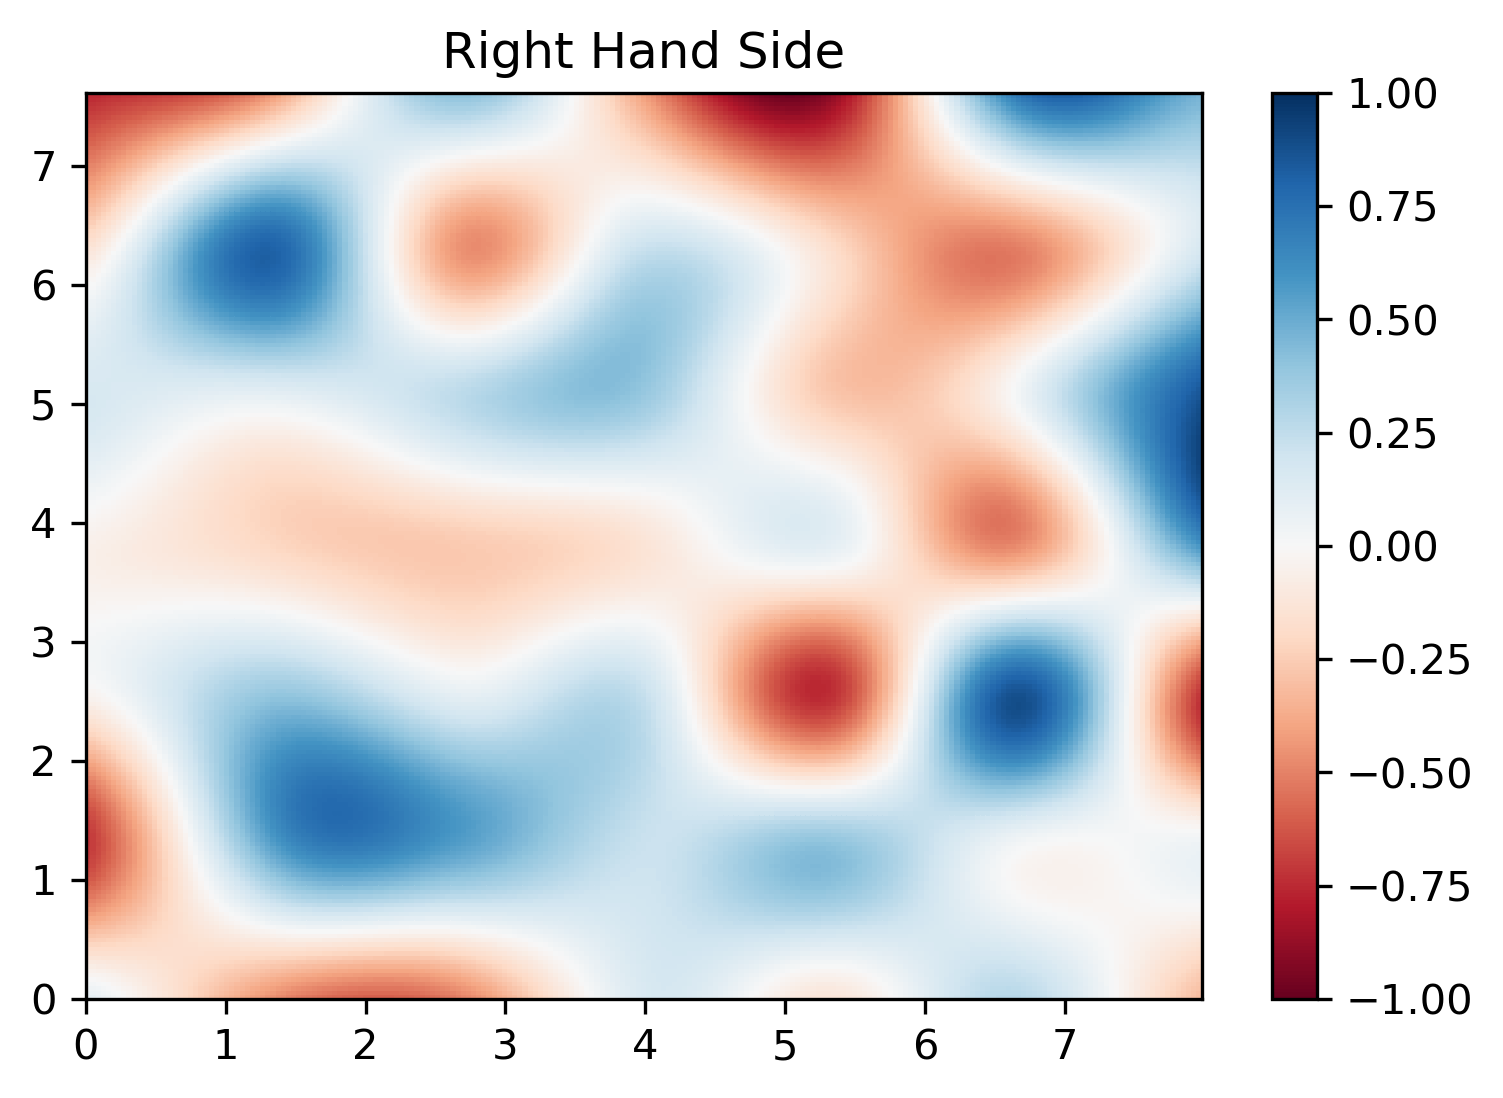

In [66]:
#p_r = np.random.randint(0,soln.shape[0])
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = inp[0][p_r,0,...]
#z_min, z_max = -np.abs(z).max(), np.abs(z).max()
z_min, z_max = -1,1
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
#c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Right Hand Side')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'rhs'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(218,)


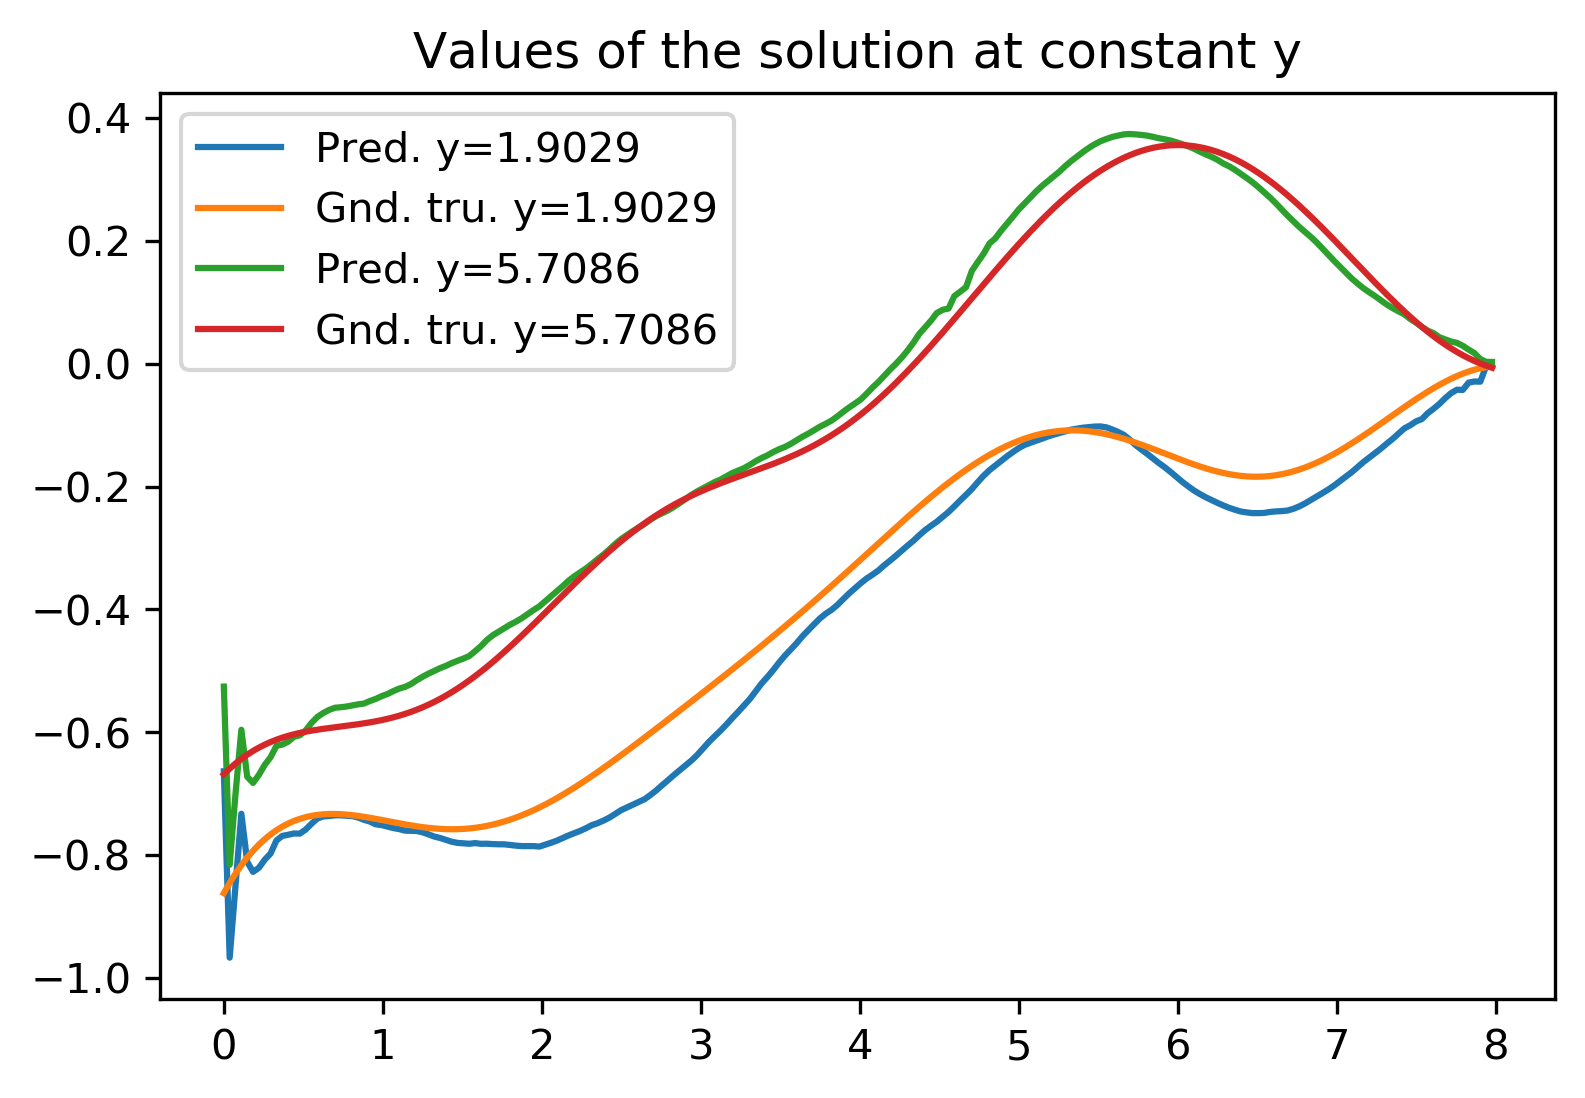

In [67]:
ypos = (soln.shape[-1]//4)
print(np.squeeze(pred[p_r,0,:,ypos]).shape)
plt.plot(x[:,0], pred[p_r,0,:,ypos], label = 'Pred. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Gnd. tru. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
ypos = (3*soln.shape[-1]//4)
plt.plot(x[:,0], pred[p_r,0,:,ypos], label = 'Pred. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Gnd. tru. y=' + ('{:.4f}'.format((ypos * inp[-1][p_r,0]).numpy())))
plt.legend()
plt.title('Values of the solution at constant y')

if saving:
    thisimage = 'consty'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

(208,)


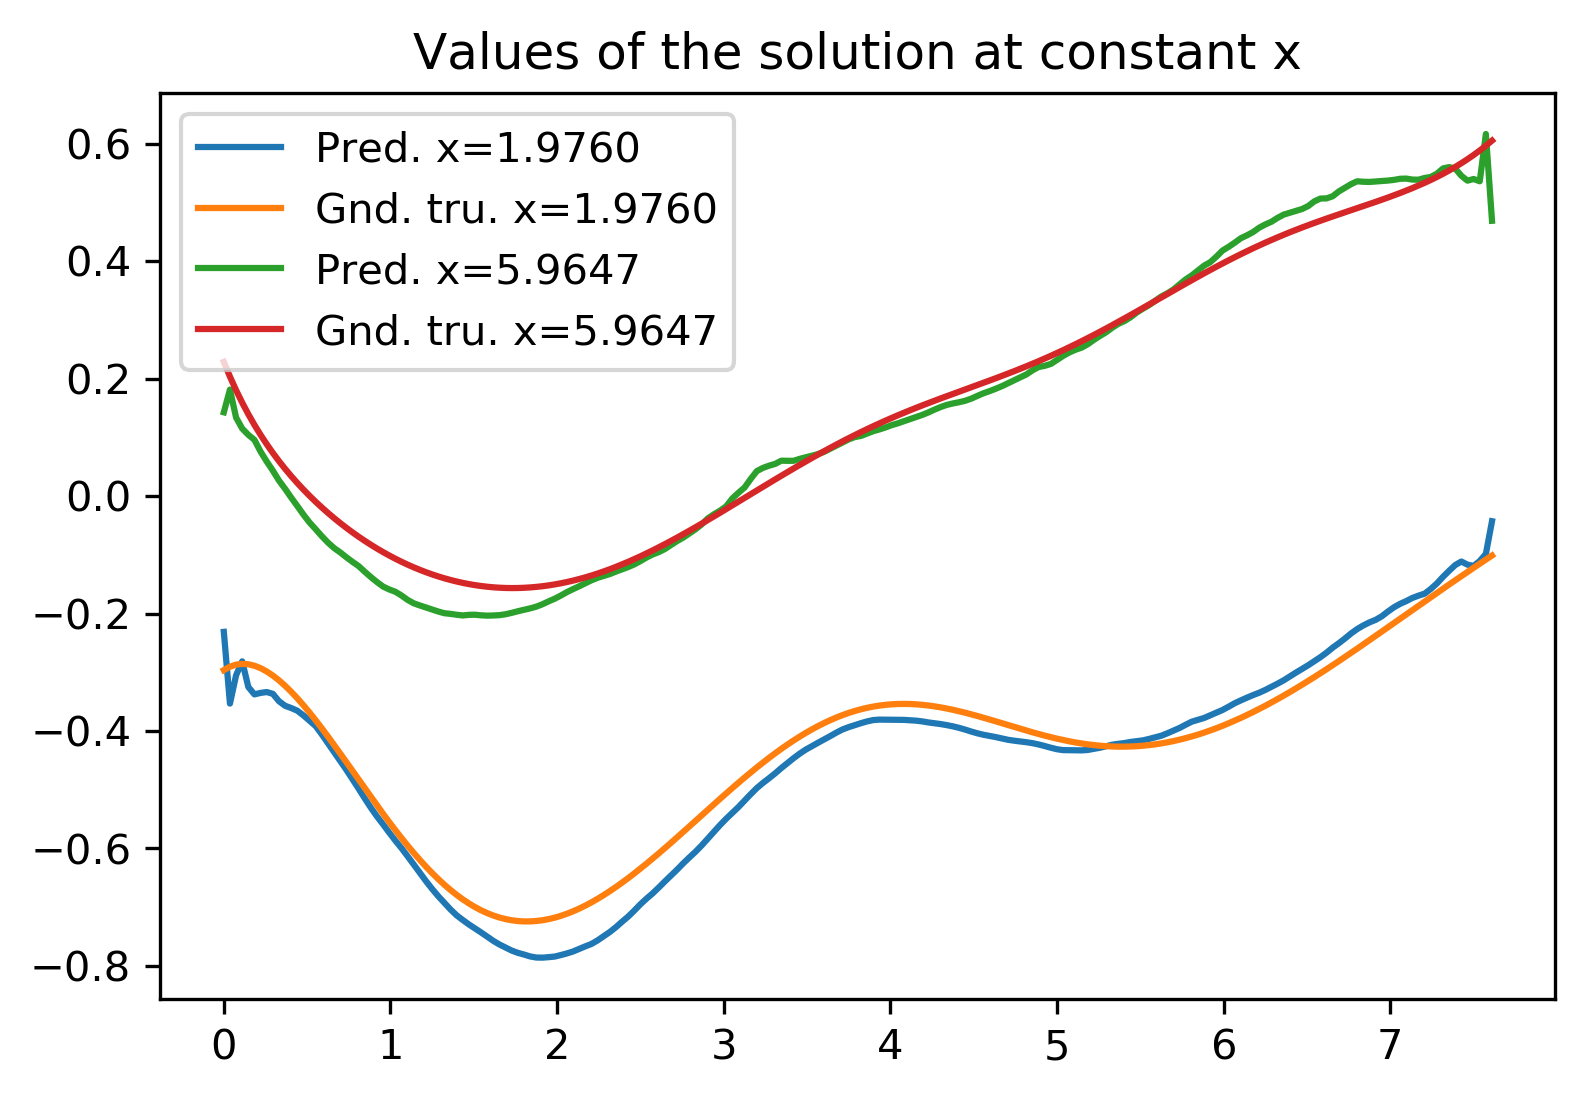

In [68]:
xpos = (soln.shape[-2]//4)
print(np.squeeze(pred[p_r,0,xpos,:]).shape)
plt.plot(y[0,:], pred[p_r,0,xpos,:], label = 'Pred. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Gnd. tru. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
xpos = (3*soln.shape[-2]//4)
plt.plot(y[0,:], pred[p_r,0,xpos,:], label = 'Pred. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Gnd. tru. x=' + ('{:.4f}'.format((xpos * inp[-1][p_r,0]).numpy())))
plt.legend()
plt.title('Values of the solution at constant x')

if saving:
    thisimage = 'constx'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

Mean absolute % error: 18.75271224975586
Mean absolute error: 0.032787104906457684
% of gridpts with less than 10% error: 38.620324629498946


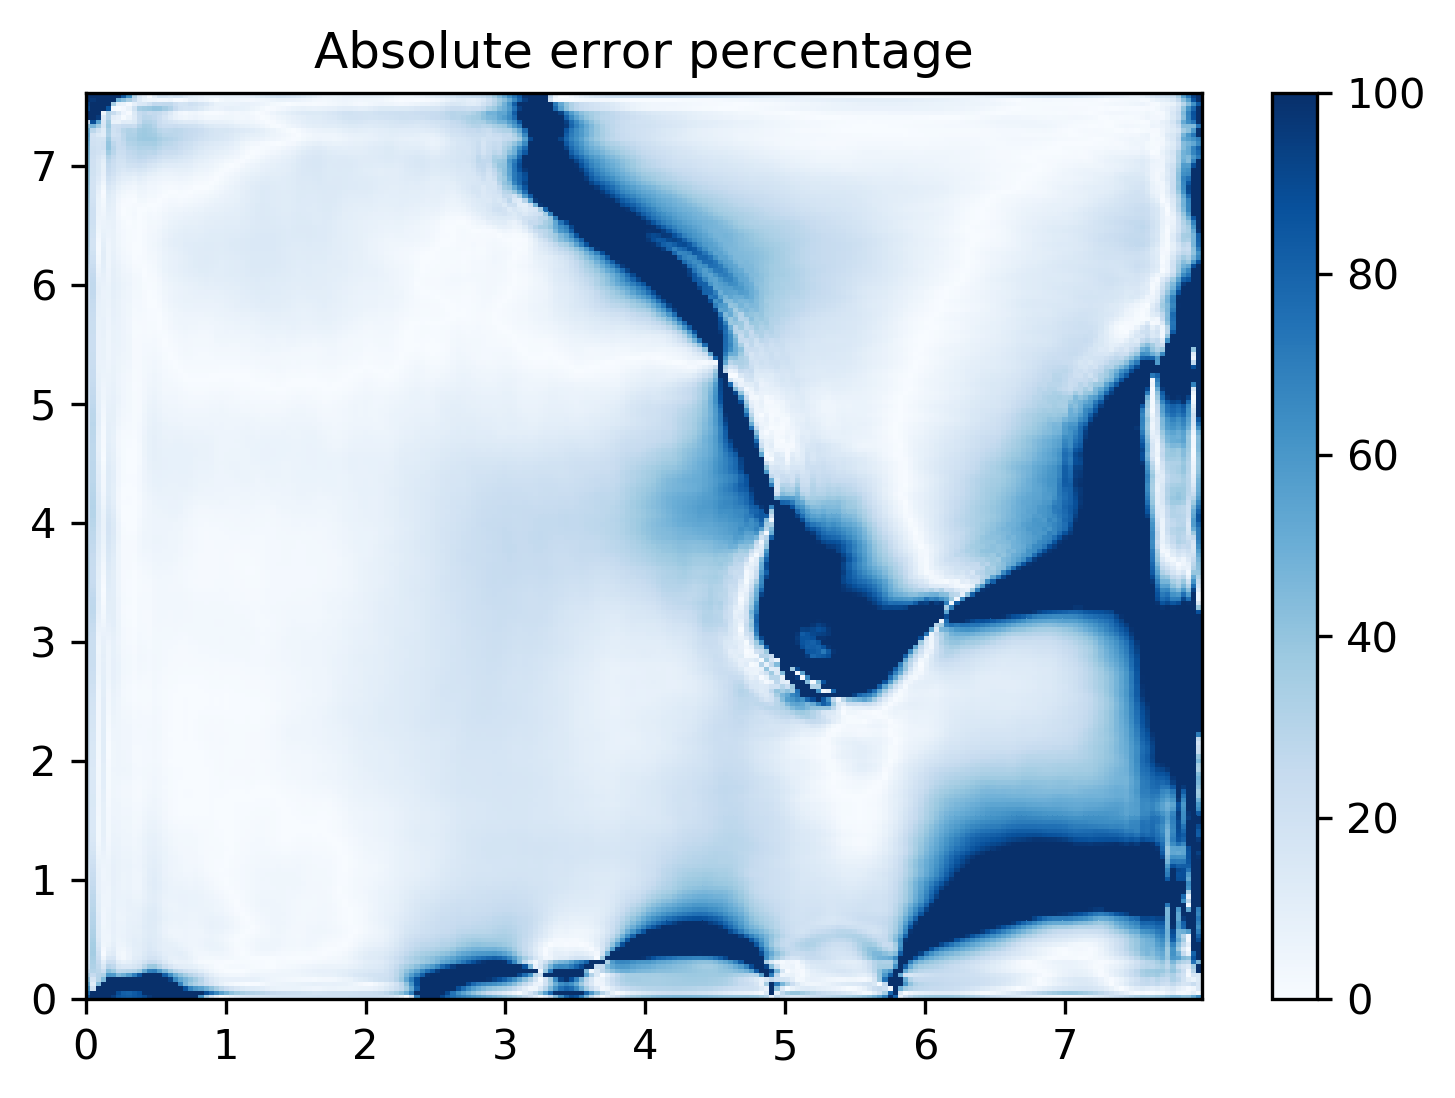

In [80]:
#p_r = np.random.randint(0,soln.shape[0])
pred = mod(inp)
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][p_r,0], soln.shape[-1]), indexing = 'ij')
#z = soln[p_r,0,...]
z = 100*tf.abs((pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))/tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))
#z = inp[0][p_r,0,...]
#z = tf.abs(pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx()))/tf.cast(soln[p_r,0,...], tf.keras.backend.floatx())
z_min, z_max = 0,100
print('Mean absolute % error: ' + str(float(np.mean(np.array(z)[np.array(z) < 100]))))
print('Mean absolute error: ' + str(float(tf.reduce_mean(tf.keras.losses.mae(pred[p_r,0,...], soln[p_r,0,...])))))
print('% of gridpts with less than 10% error: ' + str(100*float(np.sum(q[p_r,...] < 0.1)/np.prod(q.shape[2:]))))
#z_min, z_max = -1,1
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
#c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error percentage')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'percentageerrormap'
    #plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

0.03278711


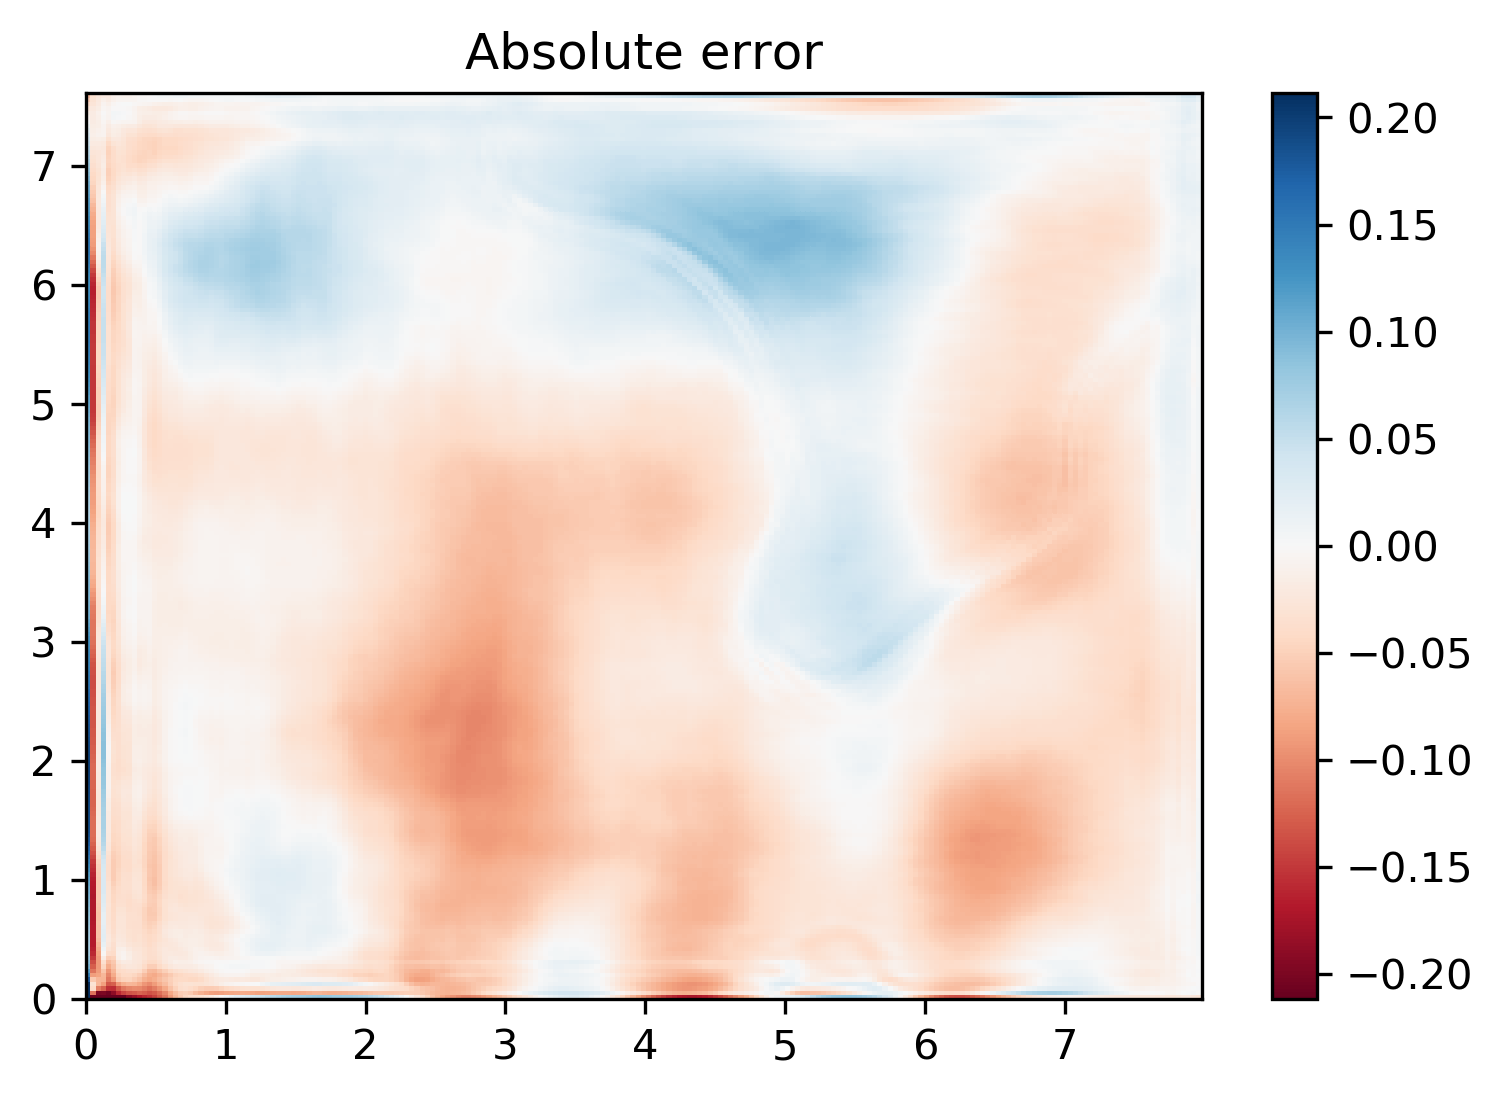

In [70]:
x, y = np.meshgrid(np.linspace(0, soln.shape[-2]*inp[-1][p_r,0], soln.shape[-2]), np.linspace(0, soln.shape[-1]*inp[-1][p_r,0], soln.shape[-1]), indexing = 'ij')
z = pred[p_r,0,...] - tf.cast(soln[p_r,0,...], tf.keras.backend.floatx())
z_min, z_max = -0.5*np.abs(z).max(), 0.5*np.abs(z).max()
print(np.mean(np.abs(z)))
#z_min, z_max = -1,1
#z_min, z_max = -0.8,0.8
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
#c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('Absolute error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

if saving:
    thisimage = 'errormap'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

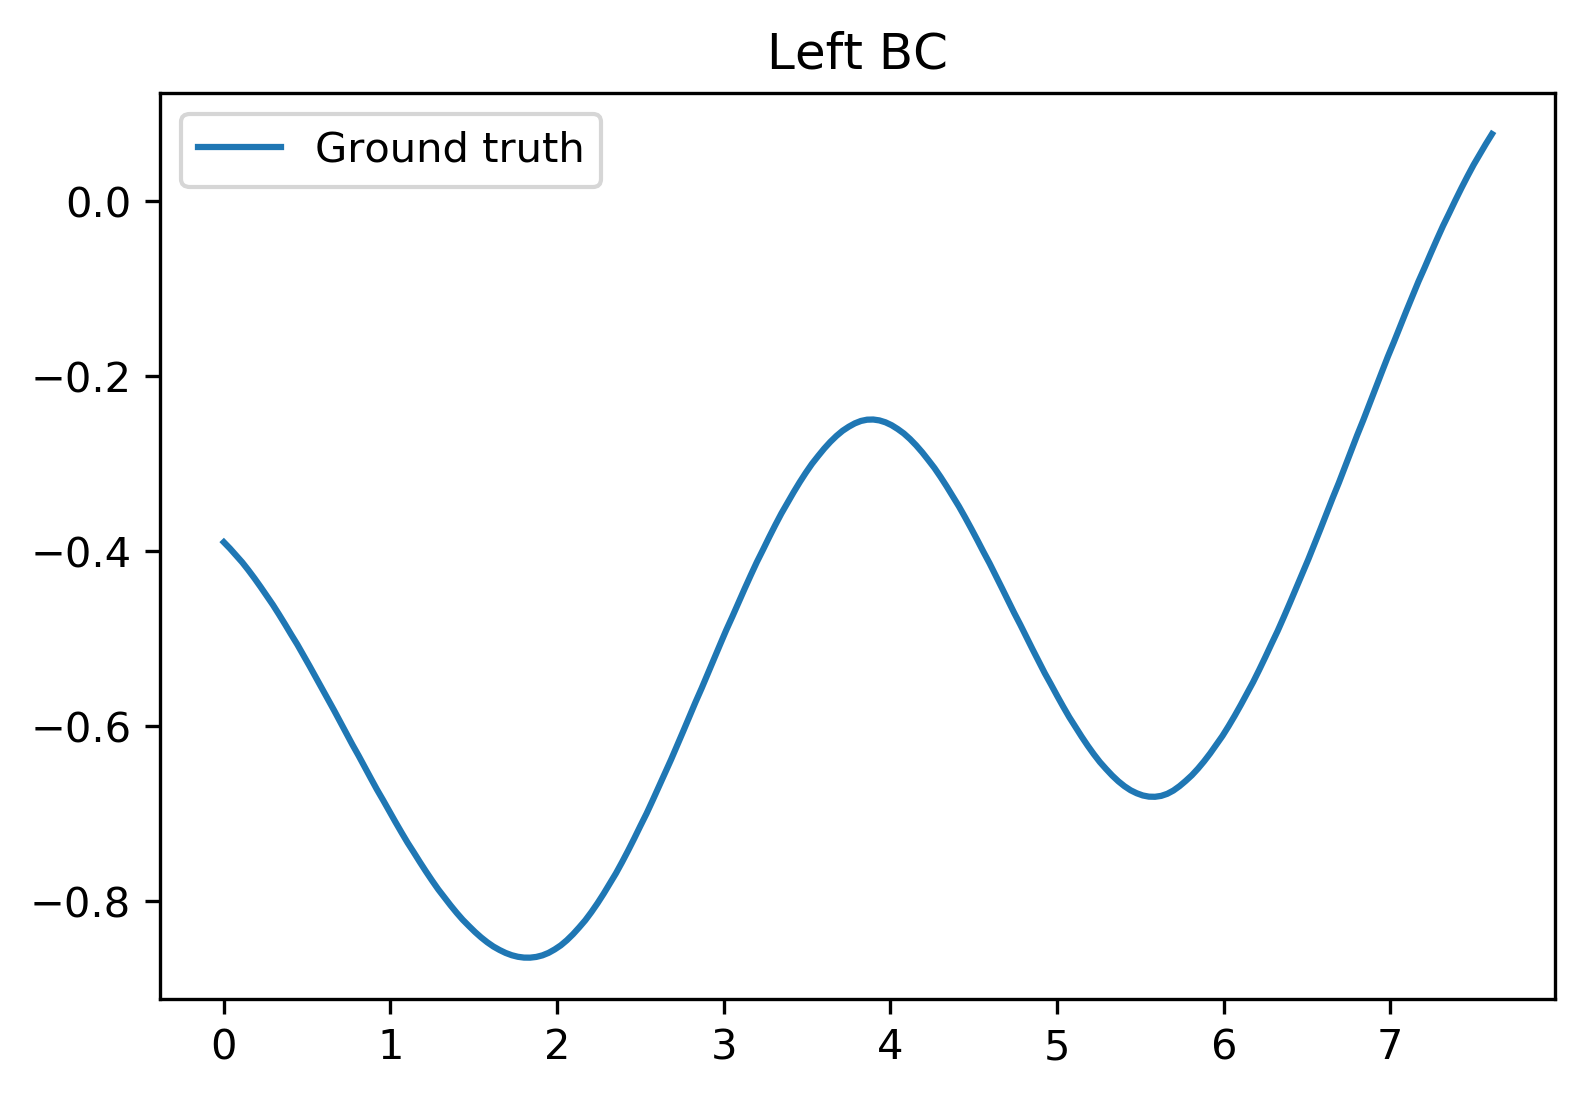

In [71]:
xpos = 0
#print(np.squeeze(pred[p_r,0,xpos,:]).shape)
#plt.plot(y[0,:], np.squeeze(pred[p_r,0,xpos,:]), label = 'Prediction')
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Ground truth')
plt.legend()
plt.title('Left BC')

if saving:
    thisimage = 'leftbc'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')


plt.show()

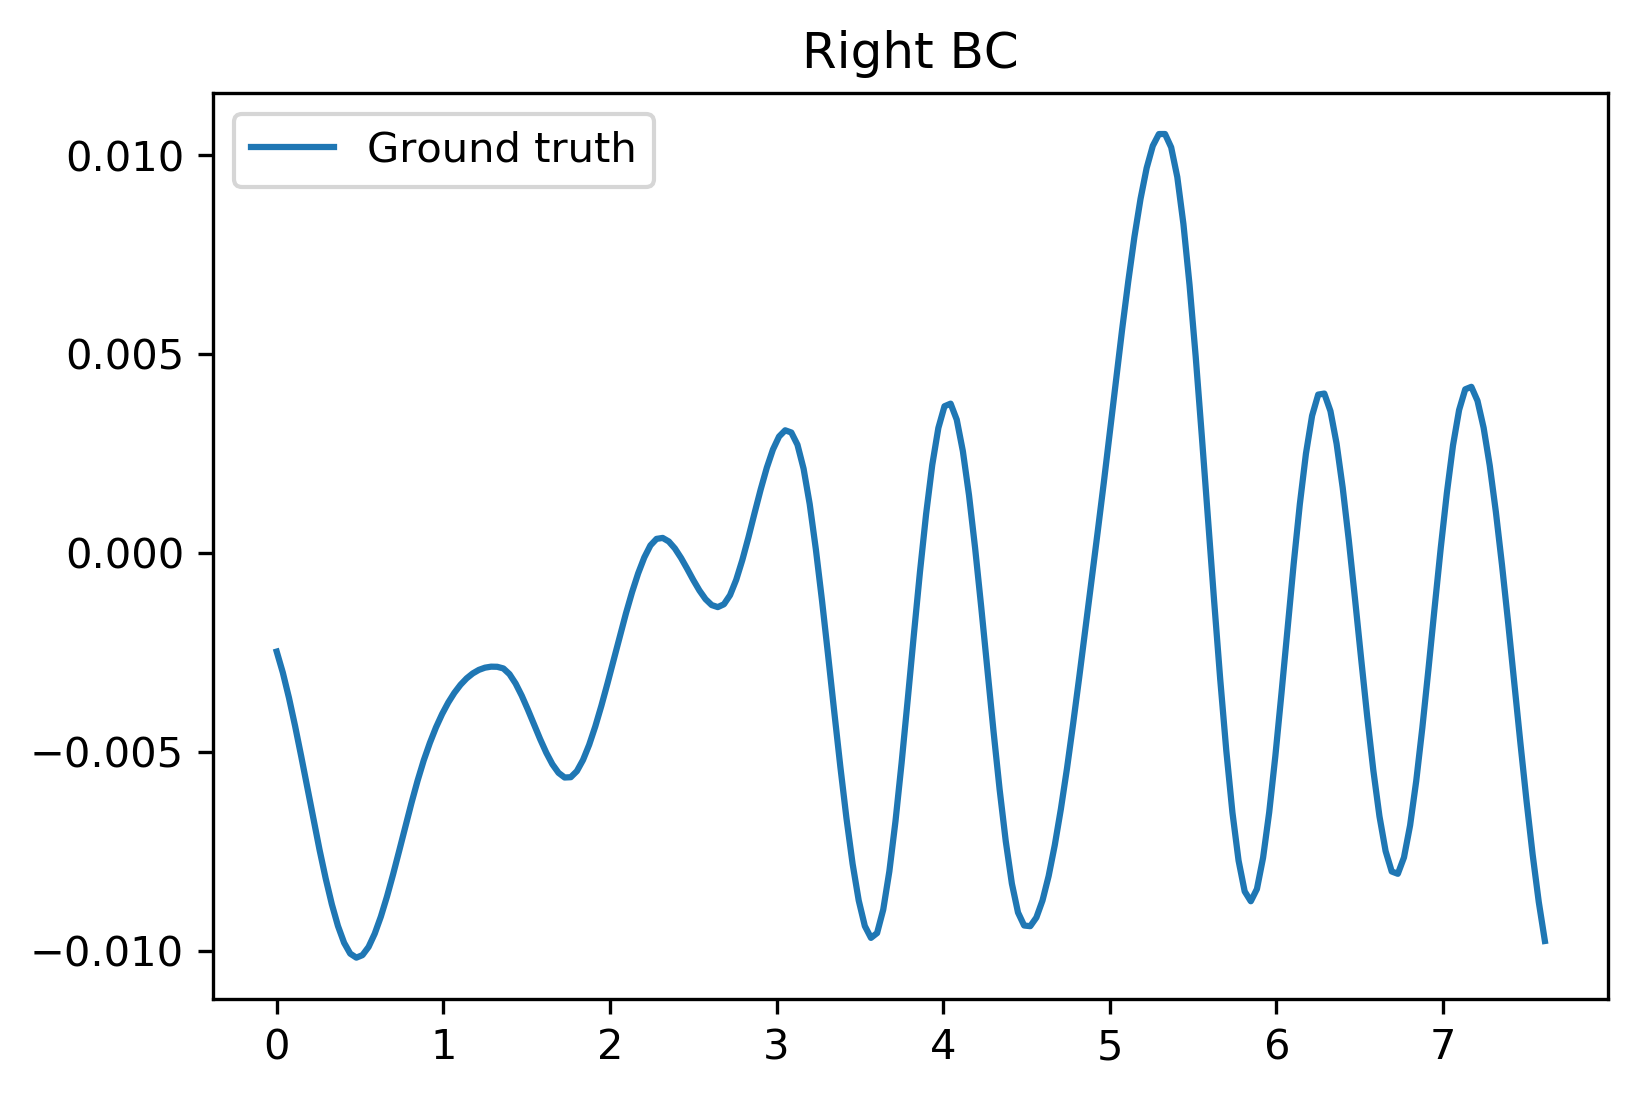

In [72]:
xpos = -1
#print(np.squeeze(pred[p_r,0,xpos,:]).shape)
#plt.plot(y[0,:], np.squeeze(pred[p_r,0,xpos,:]), label = 'Prediction')
plt.plot(y[0,:], soln[p_r,0,xpos,:], label = 'Ground truth')
plt.legend()
plt.title('Right BC')

if saving:
    thisimage = 'rightbc'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

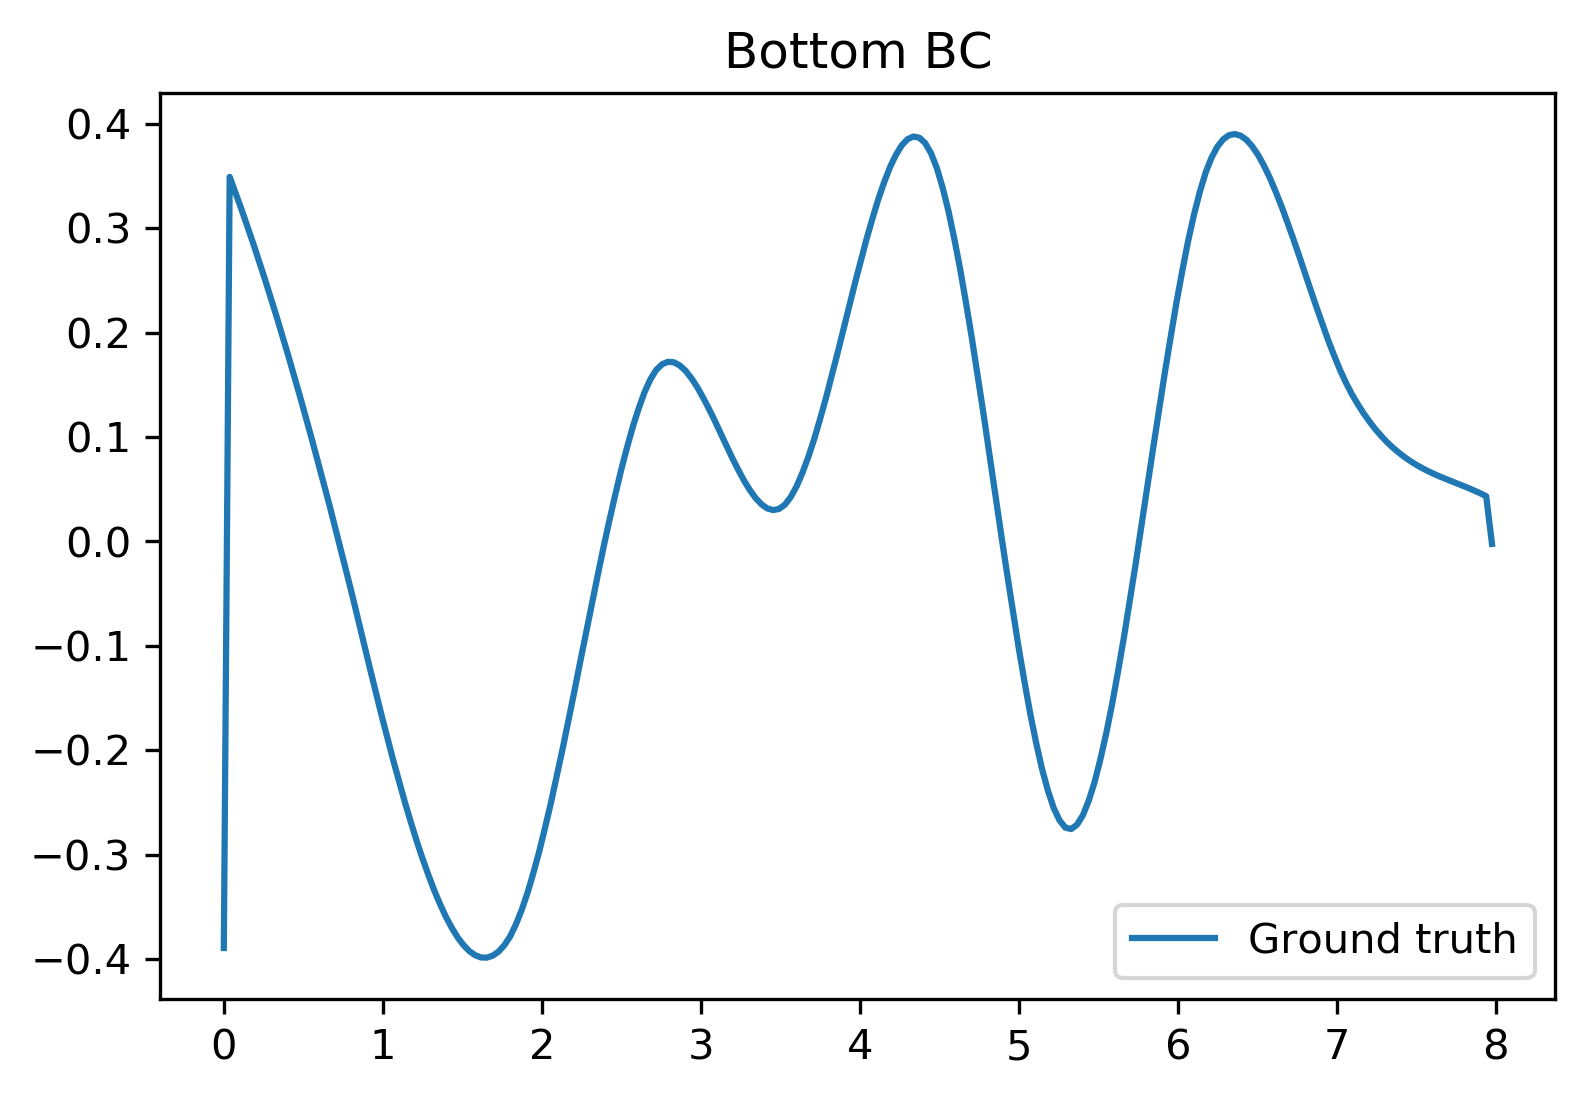

In [73]:
ypos = 0
#print(np.squeeze(pred[p_r,0,xpos,:]).shape)
#plt.plot(y[0,:], np.squeeze(pred[p_r,0,xpos,:]), label = 'Prediction')
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Ground truth')
plt.legend()
plt.title('Bottom BC')

if saving:
    thisimage = 'bottombc'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

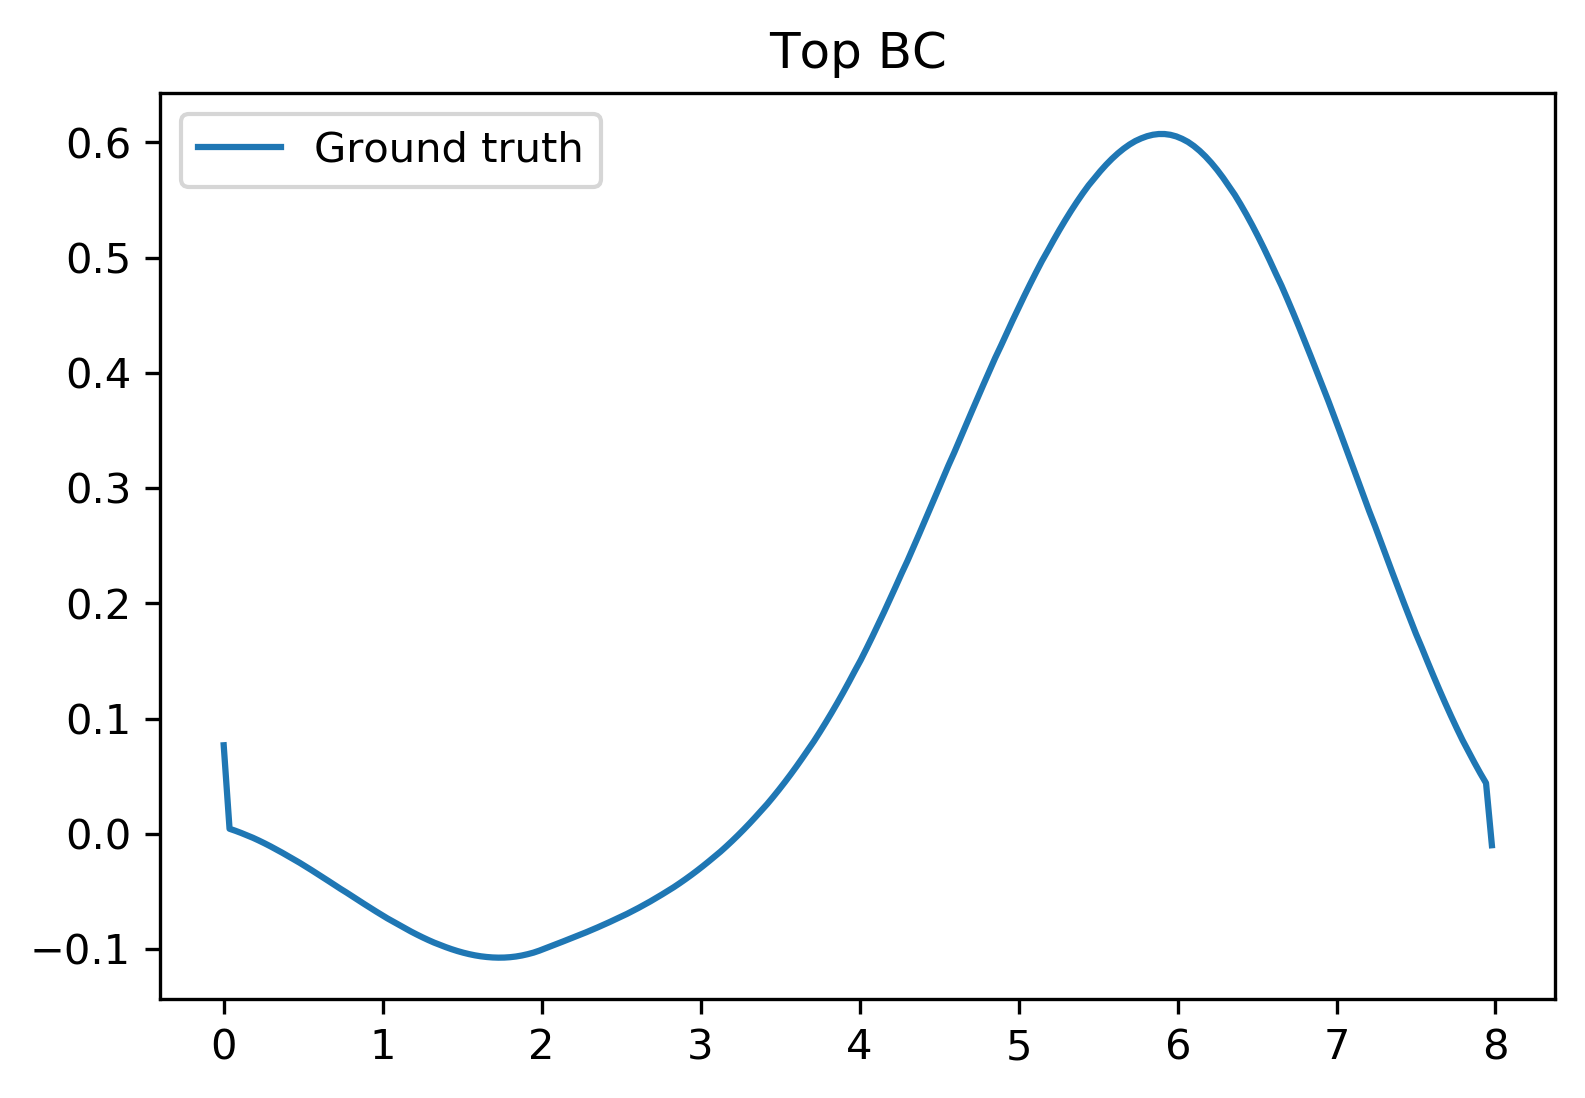

In [74]:
ypos = -1
#print(np.squeeze(pred[p_r,0,xpos,:]).shape)
#plt.plot(y[0,:], np.squeeze(pred[p_r,0,xpos,:]), label = 'Prediction')
plt.plot(x[:,0], soln[p_r,0,:,ypos], label = 'Ground truth')
plt.legend()
plt.title('Top BC')

if saving:
    thisimage = 'topbc'
    plt.savefig(img_path + examplename + '/' + examplename + identifier + case + thisimage + '.png', bbox_inches = 'tight')

plt.show()

In [76]:
rmses = []
maes = []
mapes = []
pgpb10s = []
for k in range(200):
    inp600, soln600 = dg.__getitem__(10)
    pred600 = mod(inp600)
    rms = tf.sqrt(tf.reduce_mean((pred600 - tf.cast(soln600, tf.keras.backend.floatx()))**2))
    mae = tf.reduce_mean(tf.abs(pred - tf.cast(soln, tf.keras.backend.floatx())))
    q = np.abs(pred - tf.cast(soln, tf.keras.backend.floatx()))/np.abs(tf.cast(soln, tf.keras.backend.floatx()))
    rmses.append(rms)
    maes.append(mae)
    mapes.append(100*float(tf.reduce_mean(q[q < 1])))
    pgpb10s.append(100*float(np.sum(q < 0.1)/np.prod(q.shape)))
print('Mean abs % error: ' + str(np.mean(mapes)))
print('% of gridpts with less than 10% error: ' + str(np.mean(pgpb10s)))
print('RMS error: ' + str(np.mean(rmses)))
print('MAE: ' + str(np.mean(maes)))

KeyboardInterrupt: 

In [78]:
print('Mean abs % error: ' + str(np.mean(mapes)))
print('% of gridpts with less than 10% error: ' + str(np.mean(pgpb10s)))
print('RMS error: ' + str(np.mean(rmses)))
print('MAE: ' + str(np.mean(maes)))

Mean abs % error: 25.35969316959381
% of gridpts with less than 10% error: 26.79318101623148
RMS error: 0.13923731
MAE: 0.048242956
